<h1><center></center></h1>
<h1><center>Elevvo Internship</center></h1>
<h1><center>Task 5</center></h1>
<h2><center>Topic Modeling on News Articles</center></h2>

# **Hands on Task 5**

- We build an unsupervised topic modeling pipeline using the BBC News Dataset.

- We compare two popular techniques: Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF).

- We preprocess the news articles, extract dominant topics, and visualize them with bar charts and pyLDAvis.

# **1- Data Collection**

**Setup**

In [ ]:
from google.colab import files
files.upload()

**Move kaggle.json to the correct directory**

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Install Kaggle CLI**

In [5]:
!pip install kaggle --quiet

**Download the dataset using its Kaggle identifier**

In [6]:
!kaggle datasets download -d pariza/bbc-news-summary

Dataset URL: https://www.kaggle.com/datasets/pariza/bbc-news-summary
License(s): CC0-1.0
bbc-news-summary.zip: Skipping, found more recently modified local copy (use --force to force download)


**Unzip the downloaded dataset**

In [7]:
!unzip bbc-news-summary.zip

Archive:  bbc-news-summary.zip
replace BBC News Summary/News Articles/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Import**

In [8]:
import pandas as pd
import os

**Collect article texts from all subfolders**

In [9]:
base_path = "BBC News Summary/News Articles"
categories = ["business", "entertainment", "politics", "sport", "tech"]

articles = []
labels = []

for cat in categories:
    folder = os.path.join(base_path, cat)
    for fname in os.listdir(folder):
        if fname.endswith(".txt"):
            fpath = os.path.join(folder, fname)
            with open(fpath, encoding="latin-1") as f:
                articles.append(f.read())
                labels.append(cat)

df = pd.DataFrame({"text": articles, "category": labels})
df.head()

,text,category
0,Brazil approves bankruptcy reform\n\nA major r...,business
1,US economy shows solid GDP growth\n\nThe US ec...,business
2,Business confidence dips in Japan\n\nBusiness ...,business
3,Winemaker rejects Foster's offer\n\nAustralian...,business
4,US company admits Benin bribery\n\nA US defenc...,business


**Sentence count**

In [10]:
len(df)

2225

**Label distribution**

In [11]:
df.category.value_counts()

,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


**Save for next step**

In [12]:
df.to_csv("bbc_articles_full.csv", index=False)

# **2. Preprocessing**

**Import**

In [13]:
import re
import string
import nltk

**Download NLTK resources**

In [14]:
for pkg in ["punkt", "punkt_tab", "stopwords", "wordnet", "omw-1.4"]:
    nltk.download(pkg)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


**Set up tools**

In [15]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

**Text cleaning function**

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

**Tokenization + stopword removal + lemmatization**

In [17]:
def preprocess(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

**Apply to all rows**

In [18]:
df["tokens"] = df["text"].map(preprocess)
df["clean_text"] = df["tokens"].map(lambda x: " ".join(x))
df[["text", "clean_text"]].head()

,text,clean_text
0,Brazil approves bankruptcy reform\n\nA major r...,brazil approves bankruptcy reform major reform...
1,US economy shows solid GDP growth\n\nThe US ec...,u economy show solid gdp growth u economy grow...
2,Business confidence dips in Japan\n\nBusiness ...,business confidence dip japan business confide...
3,Winemaker rejects Foster's offer\n\nAustralian...,winemaker reject foster offer australian winem...
4,US company admits Benin bribery\n\nA US defenc...,u company admits benin bribery u defence telec...


**Sentence & token count**

In [19]:
len(df), df["tokens"].map(len).sum()

(2225, 481565)

**Drop empty results if any**

In [20]:
df = df[df["tokens"].map(len) > 0].reset_index(drop=True)
len(df)

2225

**Save cleaned version**

In [21]:
df.to_csv("bbc_cleaned.csv", index=False)

# **3. Topic Modeling (LDA + NMf)**

**Install**

In [22]:
!pip -q install gensim pyLDAvis scikit-learn

In [23]:
!pip install --force-reinstall --no-cache-dir \
  "scipy==1.10.1" \
  "numpy==1.26.4" \
  "gensim==4.3.2" \
  "smart_open==6.4.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 135.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 134.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 134.3 MB/s eta 0:00:00
  Attempting uninstall: smart_open
    Found existing installation: smart-open 6.4.0
    Uninstalling smart-open-6.4.0:
      Successfully uninstalled smart-open-6.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: gensim
    Found existing 

**Set topic parameters**

In [24]:
TOPN_WORDS = 15
texts = df["tokens"].tolist()

**Build dictionary & corpus (for LDA)**

In [25]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=8000)
corpus = [dictionary.doc2bow(t) for t in texts]

len(dictionary), len(corpus)

(8000, 2225)

**Sweep over K and train LDA models**

In [26]:
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

k_values = [5, 8, 10, 12, 15, 18, 20, 25, 28, 30]
coherences = []
lda_models = {}

for k in k_values:
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=10,
        alpha="auto",
        eta="auto",
        eval_every=None
    )
    cm = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence="c_v")
    score = cm.get_coherence()
    coherences.append(score)
    lda_models[k] = lda
    print(f"K={k} → coherence: {score:.4f}")

K=5 → coherence: 0.4685
K=8 → coherence: 0.4692
K=10 → coherence: 0.5230
K=12 → coherence: 0.5134
K=15 → coherence: 0.4764
K=18 → coherence: 0.4712
K=20 → coherence: 0.4841
K=25 → coherence: 0.4686
K=28 → coherence: 0.4706
K=30 → coherence: 0.4750


**Visualize coherence vs K**

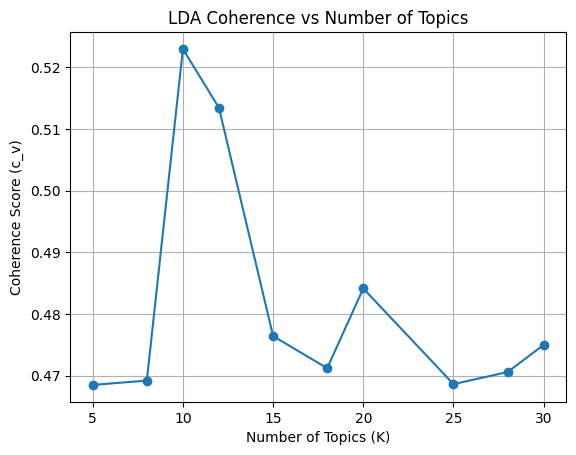

In [27]:
import matplotlib.pyplot as plt

plt.plot(k_values, coherences, marker="o")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Coherence vs Number of Topics")
plt.grid(True)
plt.show()

**Select best K**

In [28]:
import numpy as np

best_k = k_values[np.argmax(coherences)]
best_lda = lda_models[best_k]

print(f"Best K = {best_k} (coherence = {max(coherences):.4f})")

Best K = 10 (coherence = 0.5230)


**Show top words for each topic (best LDA)**

In [29]:
lda_topics = {k: [w for w, _ in best_lda.show_topic(k, topn=TOPN_WORDS)]
              for k in range(best_k)}

import pandas as pd
pd.DataFrame({
    "topic": list(lda_topics.keys()),
    "top_words": [", ".join(v) for v in lda_topics.values()]
})

,topic,top_words
0,0,"market, u, china, bn, new, growth, bank, econo..."
1,1,"technology, game, mobile, music, tv, digital, ..."
2,2,"mr, government, labour, party, minister, say, ..."
3,3,"first, second, game, win, club, time, player, ..."
4,4,"service, broadband, people, uk, bt, net, onlin..."
5,5,"best, award, game, film, top, one, england, la..."
6,6,"site, network, user, people, net, search, webs..."
7,7,"game, phone, mobile, time, people, world, get,..."
8,8,"software, security, program, virus, system, mi..."
9,9,"computer, mr, people, apple, mac, software, mi..."


**TF-IDF for NMF**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(max_features=8000, stop_words="english")
X = vect.fit_transform(df["clean_text"])
X.shape

(2225, 8000)

**Train NMF**

In [31]:
from sklearn.decomposition import NMF

nmf = NMF(n_components= 10, random_state=42, init="nndsvd", max_iter=400)
W = nmf.fit_transform(X)
H = nmf.components_
W.shape, H.shape

((2225, 10), (10, 8000))

In [32]:
# Vectorizer must be *fitted* (has idf_) and match NMF's feature size
has_idf = hasattr(vect, "idf_")
vocab_size = len(vect.get_feature_names_out())
nmf_dims = H.shape  # (n_topics, n_features)

print("Vectorizer fitted:", has_idf)
print("Vocab size:", vocab_size)
print("NMF components shape:", nmf_dims)

assert has_idf, "Vectorizer is NOT fitted. Re-run the TF-IDF cell with fit_transform, then re-run NMF."
assert nmf_dims[1] == vocab_size, "Vectorizer/NMF dimension mismatch. Re-run TF-IDF and NMF in the same run."

Vectorizer fitted: True
Vocab size: 8000
NMF components shape: (10, 8000)


**NMF: top words per topic**

In [33]:
import numpy as np

terms = vect.get_feature_names_out()
rows = []
for k, comp in enumerate(H):
    idx = np.argsort(comp)[::-1][:TOPN_WORDS]
    rows.append((k, ", ".join(terms[idx])))
pd.DataFrame(rows, columns=["topic","top_words"])

,topic,top_words
0,0,"game, club, play, win, chelsea, player, champi..."
1,1,"mr, labour, election, blair, party, brown, tor..."
2,2,"economy, growth, rate, economic, price, bank, ..."
3,3,"film, award, best, oscar, actor, festival, act..."
4,4,"mobile, phone, technology, digital, gadget, pe..."
5,5,"yukos, company, bn, firm, oil, russian, court,..."
6,6,"software, user, site, program, virus, email, s..."
7,7,"music, band, album, chart, song, single, numbe..."
8,8,"kenteris, thanou, greek, iaaf, athens, drug, t..."
9,9,"england, wale, ireland, rugby, robinson, franc..."


**NMF: coherence (c_v)**

In [34]:
from gensim.models.coherencemodel import CoherenceModel

# Prepare topic words as required by gensim
nmf_topics = []
for comp in H:
    idx = np.argsort(comp)[::-1][:TOPN_WORDS]
    topic_words = [terms[i] for i in idx]
    nmf_topics.append(topic_words)

**Compute coherence score**

In [35]:
cm_nmf = CoherenceModel(
    topics=nmf_topics,
    texts=df["tokens"].tolist(),
    dictionary=dictionary,
    coherence='c_v'
)
nmf_coherence = cm_nmf.get_coherence()
print(f"NMF Coherence Score (c_v): {nmf_coherence:.4f}")

NMF Coherence Score (c_v): 0.8198


# **4. visualization**

**prep**

In [36]:
# Each row in W is the topic distribution for a document
doc_topics = W.argmax(axis=1)

df_docs = pd.DataFrame({
    "text": df["text"],             # original article
    "clean_text": df["clean_text"], # cleaned text
    "true_category": df["category"],# original BBC category
    "topic": doc_topics             # assigned topic
})

df_docs

,text,clean_text,true_category,topic
0,Brazil approves bankruptcy reform\n\nA major r...,brazil approves bankruptcy reform major reform...,business,2
1,US economy shows solid GDP growth\n\nThe US ec...,u economy show solid gdp growth u economy grow...,business,2
2,Business confidence dips in Japan\n\nBusiness ...,business confidence dip japan business confide...,business,2
3,Winemaker rejects Foster's offer\n\nAustralian...,winemaker reject foster offer australian winem...,business,5
4,US company admits Benin bribery\n\nA US defenc...,u company admits benin bribery u defence telec...,business,5
...,...,...,...,...
2220,Microsoft plans 'safer ID' system\n\nMicrosoft...,microsoft plan safer id system microsoft plann...,tech,6
2221,Concerns over Windows ATMs\n\nCash machine net...,concern window atm cash machine network could ...,tech,6
2222,Game firm holds 'cast' auditions\n\nVideo game...,game firm hold cast audition video game firm b...,tech,4
2223,"Rich pickings for hi-tech thieves\n\nViruses, ...",rich picking hitech thief virus trojan malicio...,tech,6


**Save corpus**

In [37]:
df_docs.to_csv("documents_with_topics.csv", index=False)
len(df_docs), df_docs.columns.tolist()

(2225, ['text', 'clean_text', 'true_category', 'topic'])

**Cross‑tab (counts)**

In [38]:
import pandas as pd

ct = pd.crosstab(df_docs["true_category"], df_docs["topic"])
ct

topic,0,1,2,3,4,5,6,7,8,9
true_category,,,,,,,,,,
business,1,15,215,1,10,254,7,2,5,0
entertainment,0,4,4,216,5,4,2,148,3,0
politics,2,356,5,0,4,5,12,1,24,8
sport,259,0,0,2,0,3,0,0,94,153
tech,23,1,1,12,171,6,178,8,0,1


**Stacked bar chart (counts)**

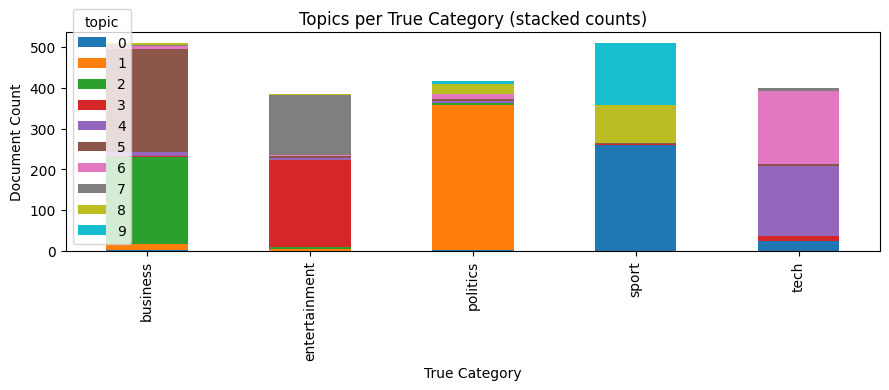

In [39]:
import matplotlib.pyplot as plt

ax = ct.plot(kind="bar", stacked=True, figsize=(9,4))
ax.set_xlabel("True Category")
ax.set_ylabel("Document Count")
ax.set_title("Topics per True Category (stacked counts)")
plt.tight_layout()
plt.show()

**Row‑normalized heatmap**

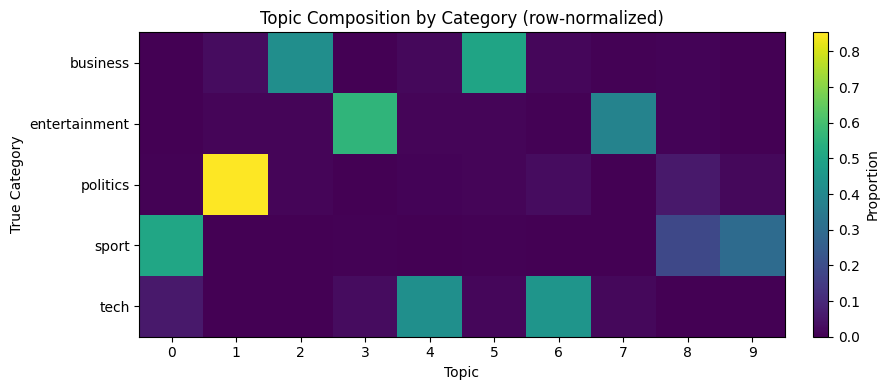

In [40]:
import numpy as np
import matplotlib.pyplot as plt

row_norm = ct.div(ct.sum(axis=1), axis=0)  # each row sums to 1
fig, ax = plt.subplots(figsize=(9,4))
im = ax.imshow(row_norm.values, aspect="auto")
ax.set_xticks(range(row_norm.shape[1])); ax.set_xticklabels(row_norm.columns)
ax.set_yticks(range(row_norm.shape[0])); ax.set_yticklabels(row_norm.index)
ax.set_xlabel("Topic"); ax.set_ylabel("True Category")
ax.set_title("Topic Composition by Category (row-normalized)")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Proportion")
plt.tight_layout(); plt.show()

**Top topic per category**

In [41]:
top_topic_per_cat = ct.idxmax(axis=1).rename("dominant_topic")
pd.DataFrame(top_topic_per_cat)

,dominant_topic
true_category,
business,5
entertainment,3
politics,1
sport,0
tech,6


**Top category per topic**

In [42]:
top_cat_per_topic = ct.idxmax(axis=0).rename("dominant_category")
pd.DataFrame(top_cat_per_topic)

,dominant_category
topic,
0,sport
1,politics
2,business
3,entertainment
4,tech
5,business
6,tech
7,entertainment
8,sport


**Purity: share of dominant topic within each category**

In [43]:
purity_by_cat = (ct.max(axis=1) / ct.sum(axis=1)).rename("purity")
pd.DataFrame(purity_by_cat).sort_values("purity", ascending=False)

,purity
true_category,
politics,0.853717
entertainment,0.559585
sport,0.506849
business,0.498039
tech,0.443890


## **4.1. Topic Visualization (pyLDAvis)**

**pyLDAvis for best LDA**

In [44]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
lda_vis = gensimvis.prepare(best_lda, corpus, dictionary)
lda_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.068028  0.112365       1        1  35.257882
3      0.212179  0.009230       2        1  15.181051
5      0.252538 -0.064201       3        1  11.958976
0     -0.030061  0.248168       4        1   9.297159
1     -0.058869 -0.087687       5        1   6.710527
7      0.002025 -0.119046       6        1   5.693380
8     -0.126382  0.016407       7        1   4.308905
6     -0.105748 -0.004444       8        1   4.191579
9     -0.092848 -0.094127       9        1   3.853707
4     -0.120860 -0.016665      10        1   3.546834, topic_info=         Term         Freq        Total Category  logprob  loglift
3843     game  1966.000000  1966.000000  Default  30.0000  30.0000
66         mr  3043.000000  3043.000000  Default  29.0000  29.0000
520    people  2006.000000  2006.000000  Default  28.0000  28.0000
2400    award   784.000000   784.000000  Default  27.0000  27.0000
149   service   832.000000   832.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
95       time    71.304183  1452.939159  Topic10  -5.3505   0.3247
141     month    63.355494   791.705496  Topic10  -5.4687   0.8137
358       get    60.769843   971.014959  Topic10  -5.5103   0.5679
69        new    60.344108  1954.145691  Topic10  -5.5174  -0.1385
208       one    58.680783  1760.639120  Topic10  -5.5453  -0.0622

[757 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7524      2  0.970460       ac
1620      1  0.123140   access
1620      4  0.004105   access
1620      5  0.045151   access
1620      6  0.098512   access
...     ...       ...      ...
6240      6  0.885558    youll
579       4  0.942020     yuan
2177      1  0.994576    yukos
3243      1  0.049939  zealand
3243      3  0.936361  zealand

[2156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 1, 2, 8, 9, 7, 10, 5])

Save

In [45]:
pyLDAvis.save_html(lda_vis, "lda_pyldavis.html")

##**4.2 Word Clouds for NMF topics**

**Install**

In [46]:
!pip -q install wordcloud

**Generate word clouds (NMF)**

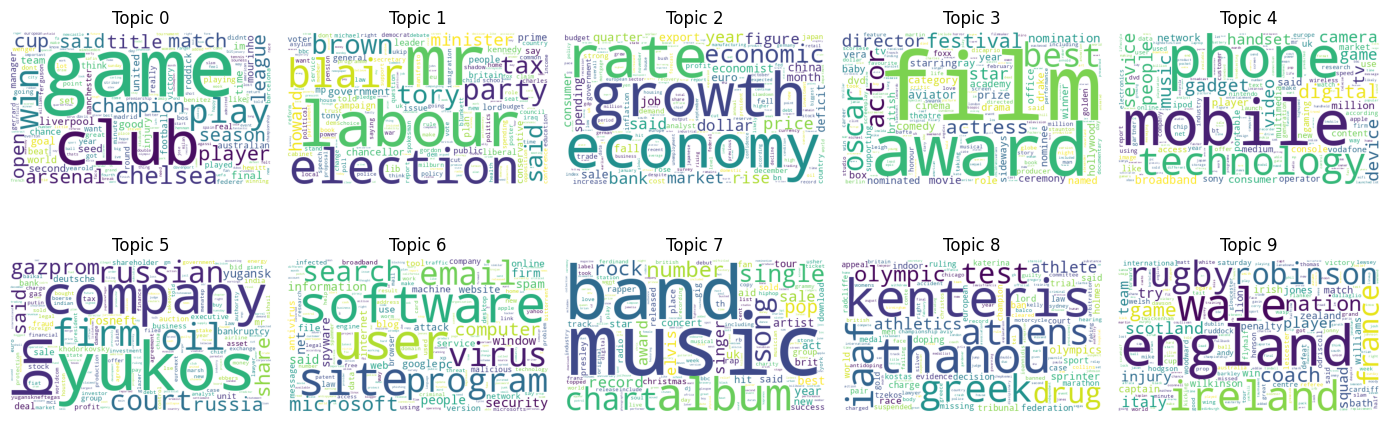

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

K = H.shape[0]
cols = 5
rows = int(np.ceil(K/cols))
fig, axes = plt.subplots(rows, cols, figsize=(14, 2.6*rows))
axes = axes.flatten()

for k in range(K):
    weights = {terms[i]: float(H[k, i]) for i in np.argsort(H[k])[::-1][:600]}
    wc = WordCloud(width=480, height=280, background_color="white").generate_from_frequencies(weights)
    axes[k].imshow(wc); axes[k].axis("off"); axes[k].set_title(f"Topic {k}")

for j in range(K, len(axes)): axes[j].axis("off")
plt.tight_layout(); plt.show()

# **5. LDA vs NMF: Comparison**

**Summary table**

In [48]:
import pandas as pd

cmp = pd.DataFrame([
    {"model": "LDA", "K": int(best_k), "coherence_c_v": float(max(coherences))},
    {"model": "NMF", "K": int(nmf.n_components), "coherence_c_v": float(nmf_coherence)},
])
cmp

,model,K,coherence_c_v
0,LDA,10,0.522953
1,NMF,10,0.819784


**Best model (by coherence)**

In [49]:
final_model = "NMF" if nmf_coherence > max(coherences) else "LDA"
print(f"Selected final model: {final_model}")

Selected final model: NMF


# **6. Exports**

In [50]:
import joblib, numpy as np, pandas as pd, json

## **6.1 Save NMF**

In [51]:
joblib.dump(vect, "tfidf_vectorizer.joblib")
joblib.dump(nmf,  "nmf_model.joblib")
print("NMF Model and Vectorizer saved!")

NMF Model and Vectorizer saved!


## **6.2 Save LDA**

In [52]:
best_lda.save("best_lda.model")
dictionary.save("dictionary.dict")
print("LDA Model and dictionary saved!")

LDA Model and dictionary saved!


In [53]:
import hashlib, joblib, pathlib

v_check = joblib.load("tfidf_vectorizer.joblib")
m_check = joblib.load("nmf_model.joblib")

print("Has idf_:", hasattr(v_check, "idf_"))
print("Vocab size:", len(v_check.get_feature_names_out()))
print("NMF components:", m_check.components_.shape)

assert hasattr(v_check, "idf_"), "Exported vectorizer not fitted"
assert m_check.components_.shape[1] == len(v_check.get_feature_names_out()), "Vectorizer/model mismatch"

def sha16(p):
    return hashlib.sha256(open(p, "rb").read()).hexdigest()[:16]

for p in ["tfidf_vectorizer.joblib", "nmf_model.joblib", "documents_with_topics.csv"]:
    pp = pathlib.Path(p)
    if pp.exists():
        print(p, "size:", pp.stat().st_size, "sha16:", sha16(p))

Has idf_: True
Vocab size: 8000
NMF components: (10, 8000)
tfidf_vectorizer.joblib size: 296343 sha16: a98b6882033a3868
nmf_model.joblib size: 640675 sha16: 2511a2724b0aaf74
documents_with_topics.csv size: 8485057 sha16: c6ffa06d43e21f56


**Build "dominant_category" + "purity" for each NMF topic and save**

In [54]:

top_cat_per_topic = ct.idxmax(axis=0)
pur_topic = (ct.max(axis=0) / ct.sum(axis=0))

# Attach NMF keywords (optional, useful for auditing)
terms = vect.get_feature_names_out()
def top_words(comp, n=12):
    idx = np.argsort(comp)[::-1][:n]
    return [terms[i] for i in idx]

topic_meta = pd.DataFrame({
    "dominant_category": top_cat_per_topic,
    "purity": pur_topic,
    "keywords": [top_words(H[k], 12) for k in range(H.shape[0])]
})
topic_meta.to_json("topic_to_category_nmf.json", orient="index")
topic_meta

,dominant_category,purity,keywords
topic,,,
0,sport,0.908772,"[game, club, play, win, chelsea, player, champ..."
1,politics,0.946809,"[mr, labour, election, blair, party, brown, to..."
2,business,0.955556,"[economy, growth, rate, economic, price, bank,..."
3,entertainment,0.935065,"[film, award, best, oscar, actor, festival, ac..."
4,tech,0.900000,"[mobile, phone, technology, digital, gadget, p..."
5,business,0.933824,"[yukos, company, bn, firm, oil, russian, court..."
6,tech,0.894472,"[software, user, site, program, virus, email, ..."
7,entertainment,0.930818,"[music, band, album, chart, song, single, numb..."
8,sport,0.746032,"[kenteris, thanou, greek, iaaf, athens, drug, ..."


**Save a tiny model card so the app can show metrics in the UI**

In [55]:
import json
metrics = {
    "NMF": {"K": int(nmf.n_components), "coherence_c_v": float(nmf_coherence)},
    "LDA": {"K": int(best_k), "coherence_c_v": float(max(coherences))}
}
with open("model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Wrote model_metrics.json")

Wrote model_metrics.json
